In [1]:
# This notebook comes from: https://www.kaggle.com/salaheddinebouzdouz/bankruptcy-prediction-f1-score-98
# Import necessary libraries
import numpy as np
from numpy import median
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from scipy import stats
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score, precision_score, plot_precision_recall_curve
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore") 
# Import data
data = pd.read_csv('data.csv')

In [3]:
data.head()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.457733    
4                                           0.522298    

    Operating Gross Margin   Realized Sales Gross Margin  \
0                 0.601457                      0.601457   
1                 0.610235                      0.610235   
2                 0.601450                      0.601364   
3                 0.583541                      0.583541   
4                 0.598783                      0.598783   

    Operating Profit Rate   Pre-tax net Interest Rate  \
0                0.998969                    0.796887   
1                0.998946                    0.797380   
2                0.998857                    0.796403   
3                0.998700                    0.796967   
4                0.998973                    0.797366   

    After-tax net Interest Rate   Non-industry income and expenditure/revenue  \
0                      0.808809                                      0.302646   
1                      0.809301                                      0.303556   
2                      0.808388                                      0.302035   
3                      0.808966                                      0.303350   
4                      0.809304                                      0.303475   

   ...   Net Income to Total Assets   Total assets to GNP price  \
0  ...                     0.716845                    0.009219   
1  ...                     0.795297                    0.008323   
2  ...                     0.774670                    0.040003   
3  ...                     0.739555                    0.003252   
4  ...                     0.795016                    0.003878   

    No-credit Interval   Gross Profit to Sales  \
0             0.622879                0.601453   
1             0.623652                0.610237   
2             0.623841                0.601449   
3             0.622929                0.583538   
4             0.623521                0.598782   

    Net Income to Stockholder's Equity   Liability to Equity  \
0                             0.827890              0.290202   
1                             0.839969              0.283846   
2                             0.836774              0.290189   
3                             0.834697              0.281721   
4                             0.839973              0.278514   

    Degree of Financial Leverage (DFL)  \
0                             0.026601   
1                             0.264577   
2                             0.026555   
3                             0.026697   
4                             0.024752   

    Interest Coverage Ratio (Interest expense to EBIT)   Net Income Flag  \
0                                           0.564050                   1   
1                                           0.570175                   1   
2                                           0.563706                   1   
3                                           0.564663                   1   
4                        

In [4]:
# Create copy of df
df = data.copy()
# Check Missing data
df.isnull().sum().any()

False

In [5]:
# Shape of df
print("Number of rows : {}".format(df.shape[0]), '\n'
      "Number of cols : {}".format(df.shape[1]))

Number of rows : 6819 
Number of cols : 96


In [6]:
# Set X and y 
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
# Set training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Optimal number of features : 32


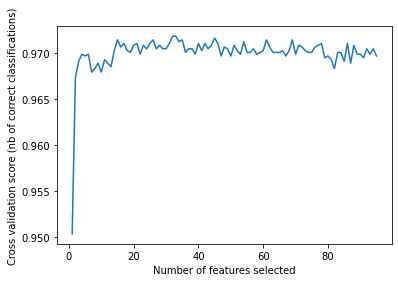

In [7]:
# Set RandomForestClassifier as estimator for RFECV
cart = RandomForestClassifier(random_state=42)
# Minimum number of features to consider
min_features_to_select = 1  
# Set number of folds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1) 
# Set cross-validation process
rfecv = RFECV(estimator=cart, step=1, cv=cv,
              scoring='accuracy',
              min_features_to_select=min_features_to_select, n_jobs=1)
# Fit the model
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [8]:
most_relevent_cols = df.iloc[:, 1:].columns[np.where(rfecv.support_ == True)]
print("Most relevant features are: ")
print(most_relevent_cols)

Most relevant features are: 
Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' Non-industry income and expenditure/revenue',
       ' Interest-bearing debt interest rate', ' Net Value Per Share (B)',
       ' Net Value Per Share (A)', ' Net Value Per Share (C)',
       ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (Yuan ¥)', ' Net Value Growth Rate',
       ' Total Asset Return Growth Rate Ratio', ' Quick Ratio',
       ' Interest Expense Ratio', ' Total debt/Total net worth',
       ' Net worth/Assets', ' Borrowing dependency',
       ' Net profit before tax/Paid-in capital',
       ' Accounts Receivable Turnover', ' Inventory Turnover Rate (times)',
       ' Fixed Assets Turnover Frequency', ' Allocation rate per person',
       ' Cash/Total Assets', ' Cash/Current Liability',
       ' Inventory/Working Capital', ' Working Capital/Equity',
       ' Net Income to Total As

In [9]:
most_relevent_cols = list(most_relevent_cols)
most_relevent_cols.append("Bankrupt?")

In [10]:
# Display df
rfecv_df = df[most_relevent_cols]
rfecv_df.head()

ROA(C) before interest and depreciation before interest  \
0                                           0.370594          
1                                           0.464291          
2                                           0.426071          
3                                           0.399844          
4                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    Non-industry income and expenditure/revenue  \
0                                      0.302646   
1                                      0.303556   
2                                      0.302035   
3                                      0.303350   
4                                      0.303475   

    Interest-bearing debt interest rate   Net Value Per Share (B)  \
0                              0.000725                  0.147950   
1                              0.000647                  0.182251   
2                              0.000790                  0.177911   
3                              0.000449                  0.154187   
4                              0.000686                  0.167502   

    Net Value Per Share (A)   Net Value Per Share (C)  \
0                  0.147950                  0.147950   
1                  0.182251                  0.182251   
2                  0.177911                  0.193713   
3                  0.154187                  0.154187   
4                  0.167502                  0.167502   

    Persistent EPS in the Last Four Seasons  \
0                                  0.169141   
1                                  0.208944   
2                                  0.180581   
3                                  0.193722   
4                                  0.212537   

    Per Share Net profit before tax (Yuan ¥)   Net Value Growth Rate  ...  \
0                                   0.138736                0.000327  ...   
1                                   0.169918                0.000443  ...   
2                                   0.142803                0.000396  ...   
3                                   0.148603                0.000382  ...   
4                                   0.168412                0.000439  ...   

    Inventory/Working Capital   Working Capital/Equity  \
0                    0.276920                 0.721275   
1                    0.289642                 0.731975   
2                    0.277456                 0.742729   
3                    0.276580                 0.729825   
4                    0.287913                 0.732000   

    Net Income to Total Assets   Total assets to GNP price  \
0                     0.716845                    0.009219   
1                     0.795297                    0.008323   
2                     0.774670                    0.040003   
3                     0.739555                    0.003252   
4                     0.795016                    0.003878   

    No-credit Interval   Net Income to Stockholder's Equity  \
0             0.622879                             0.827890   
1             0.623652                             0.839969   
2             0.623841                             0.836774   
3             0.622929                             0.834697   
4             0.623521                             0.839973   

    Degree of Financial Leverage (DFL)  \
0                             0.026601   
1                             0.264577   
2                             0.026555   
3                             0.026697   
4                             0.024752   

    Interest Coverage Ratio (Interest expense to EBIT)   Equity to Liability  \
0                                           0.564050                0.016469   
1                      

In [11]:
# Descriptive stats
rfecv_df.describe()

ROA(C) before interest and depreciation before interest  \
count                                        6819.000000          
mean                                            0.505180          
std                                             0.060686          
min                                             0.000000          
25%                                             0.476527          
50%                                             0.502706          
75%                                             0.535563          
max                                             1.000000          

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                                   0.535543   
50%                                   0.559802   
75%                                   0.589157   
max                                   1.000000   

        Non-industry income and expenditure/revenue  \
count                                   6819.000000   
mean                                       0.303623   
std                                        0.011163   
min                                        0.000000   
25%                                        0.303466   
50%                                        0.303525   
75%                                        0.303585   
max                                        1.000000   

        Interest-bearing debt interest rate   Net Value Per Share (B)  \
count                          6.819000e+03               6819.000000   
mean                           1.644801e+07                  0.190661   
std                            1.082750e+08                  0.033390   
min                            0.000000e+00                  0.000000   
25%                            2.030203e-04                  0.173613   
50%                            3.210321e-04                  0.184400   
75%                            5.325533e-04                  0.199570   
max                            9.900000e+08                  1.000000   

        Net Value Per Share (A)   Net Value Per Share (C)  \
count               6819.000000               6819.000000   
mean                   0.190633                  0.190672   
std                    0.033474                  0.033480   
min                    0.000000                  0.000000   
25%                    0.173613                  0.173676   
50%                    0.184400                  0.184400   
75%                    0.199570                  0.199612   
max                    1.000000                  1.000000   

        Persistent EPS in the Last Four Seasons  \
count                               6819.000000   
mean                                   0.228813   
std                                    0.033263   
min                                    0.000000   
25%                                    0.214711   
50%                                    0.224544   
75%                                    0.238820   
max                                    1.000000   

        Per Share Net profit before tax (Yuan ¥)   Net Value Growth Rate  ...  \
count                                6819.000000            6.819000e+03  ...   
mean                                    0.184361            1.566212e+06  ...   
std                                     0.033180            1.141594e+08  ...   
min                                     0.000000            0.000000e+00  ...   
25%                                     0.170370            4.409689e-04  ...   
50%                                     0.179709            4.619555e-04  ...   
75%                                     0.193493            4.993621e-04  ...   
max                                     1.000000            9.330000e+09  ...   

        Inventory/Working Capital   Working Capital/Equity 

% of Data
0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64
Count
0    6599
1     220
Name: Bankrupt?, dtype: int64


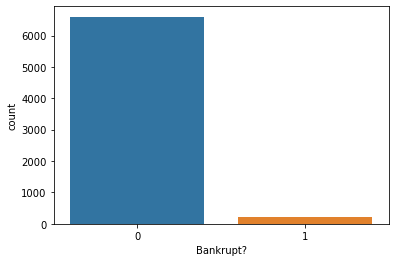

In [12]:
# Analyse target var
sns.countplot(rfecv_df['Bankrupt?'])
# Target 
print("% of Data") 
print(df['Bankrupt?'].value_counts(normalize=True))
print("Count")
print(df['Bankrupt?'].value_counts())

In [16]:
## What we can see in the graph bellow is that most features don't follow a normal distribution and many of them have very skwed distribution. This can be later one solved by using the replate extreme values with the median

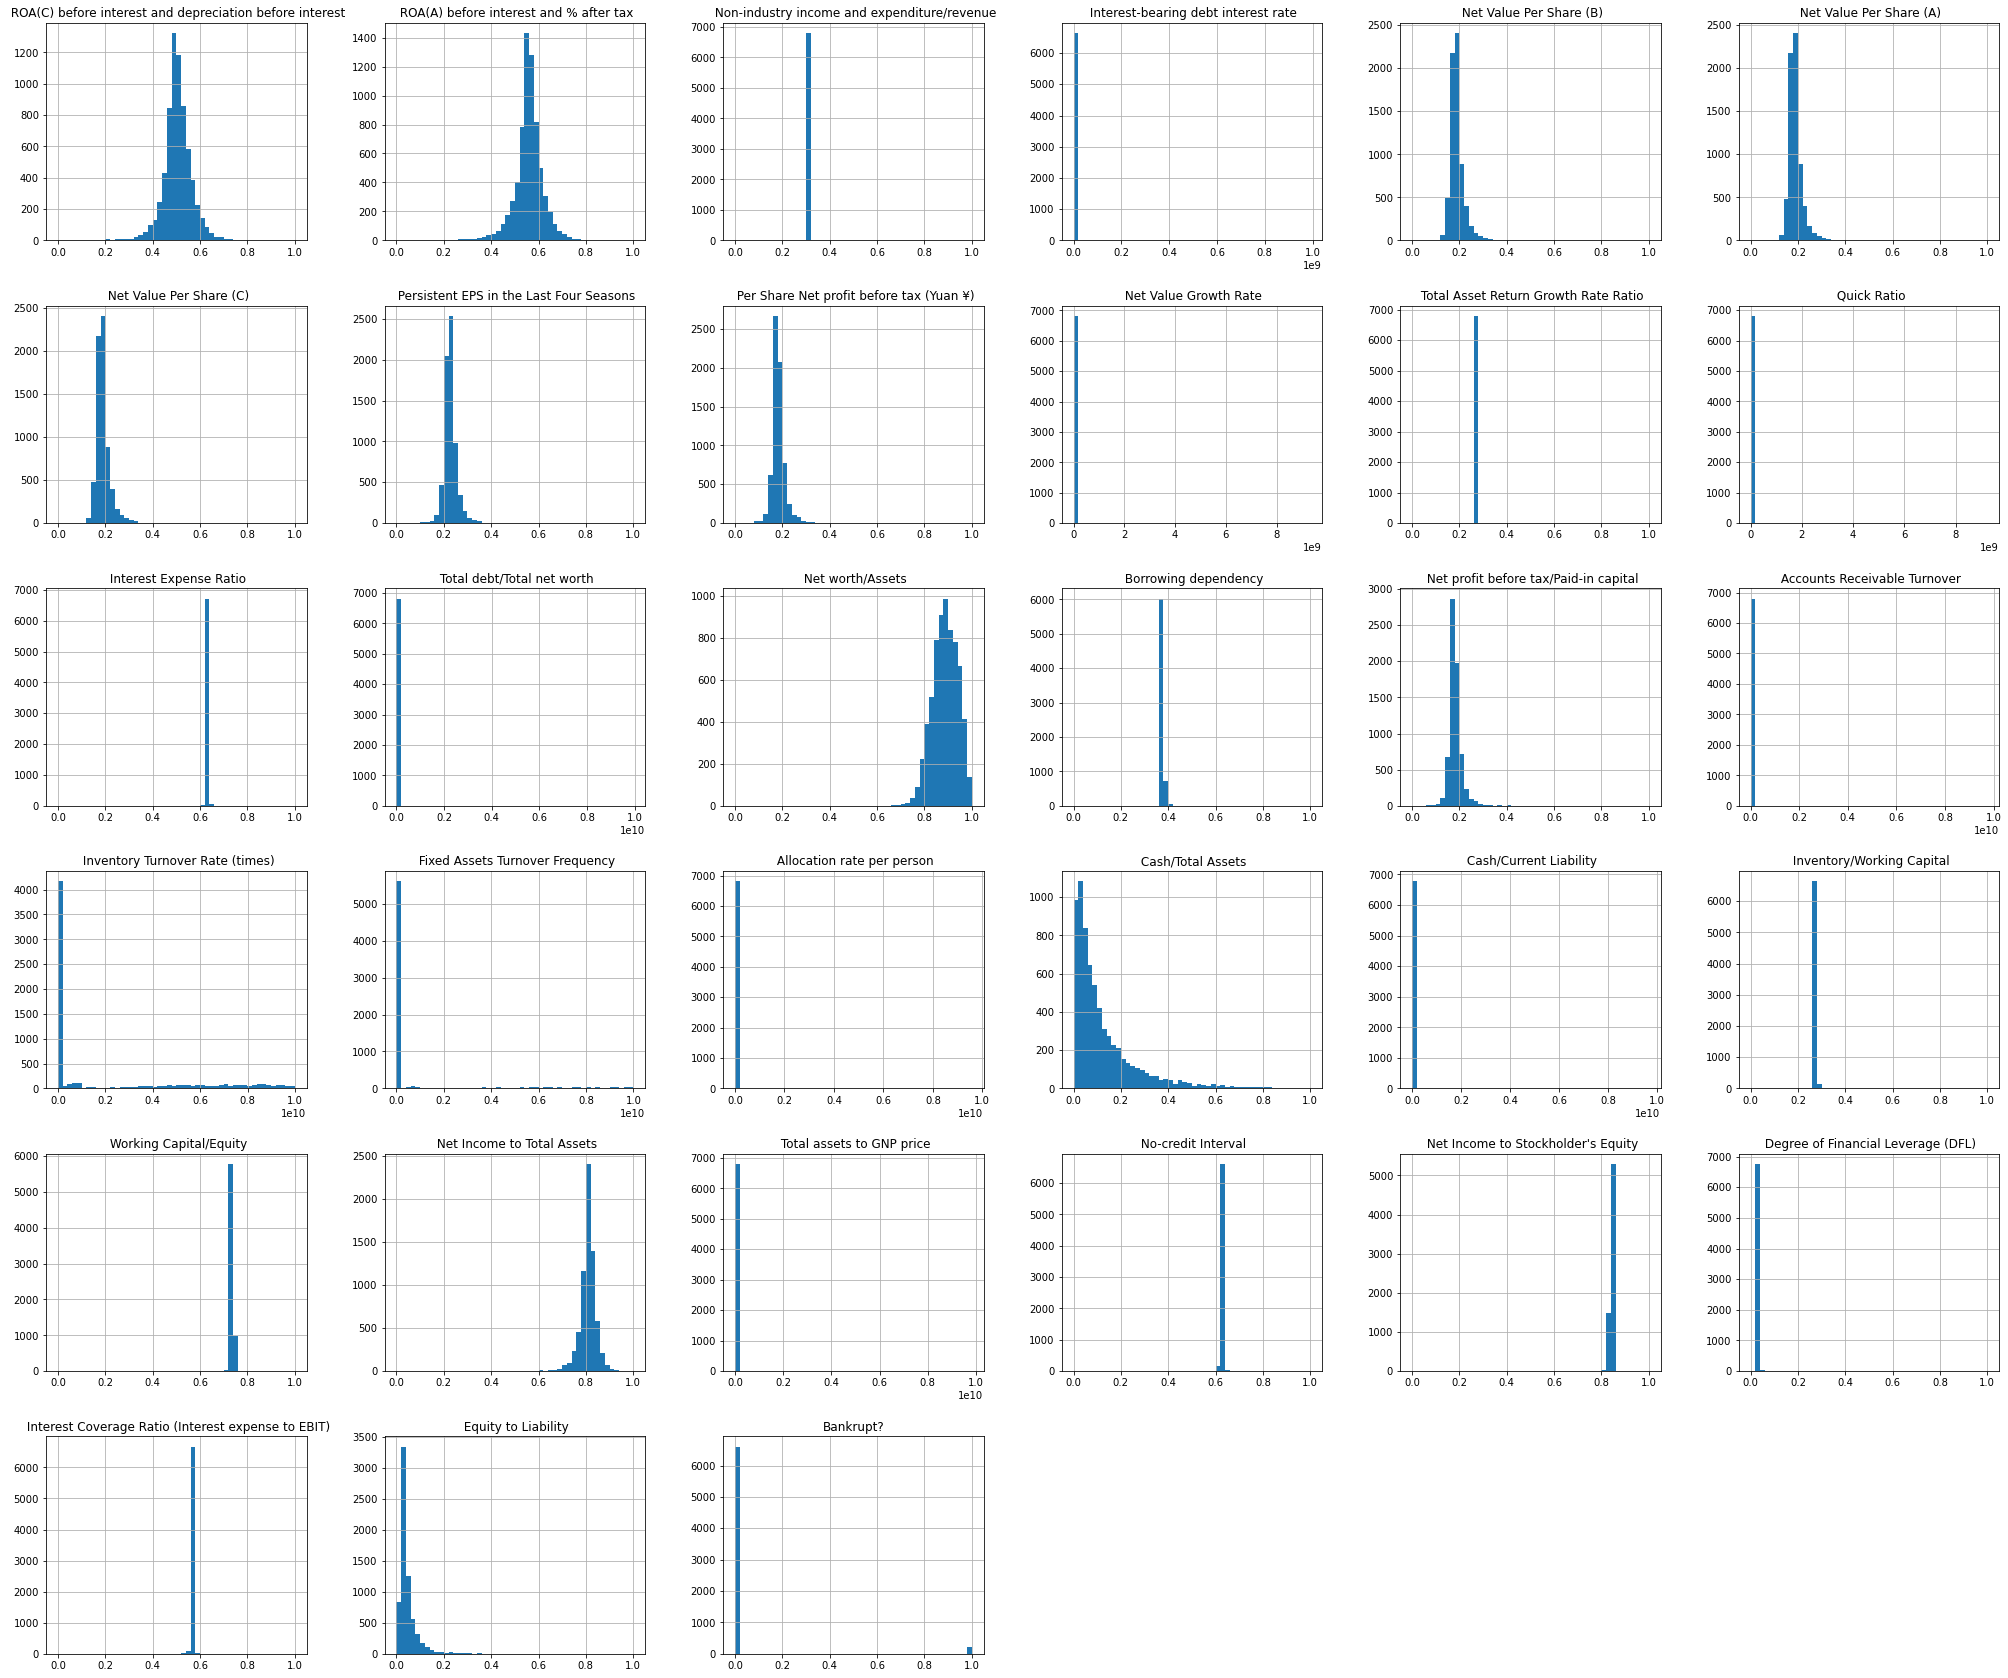

In [13]:
# Looking at the histograms of numerical data
rfecv_df.hist(figsize = (35,30), bins = 50)
plt.show()

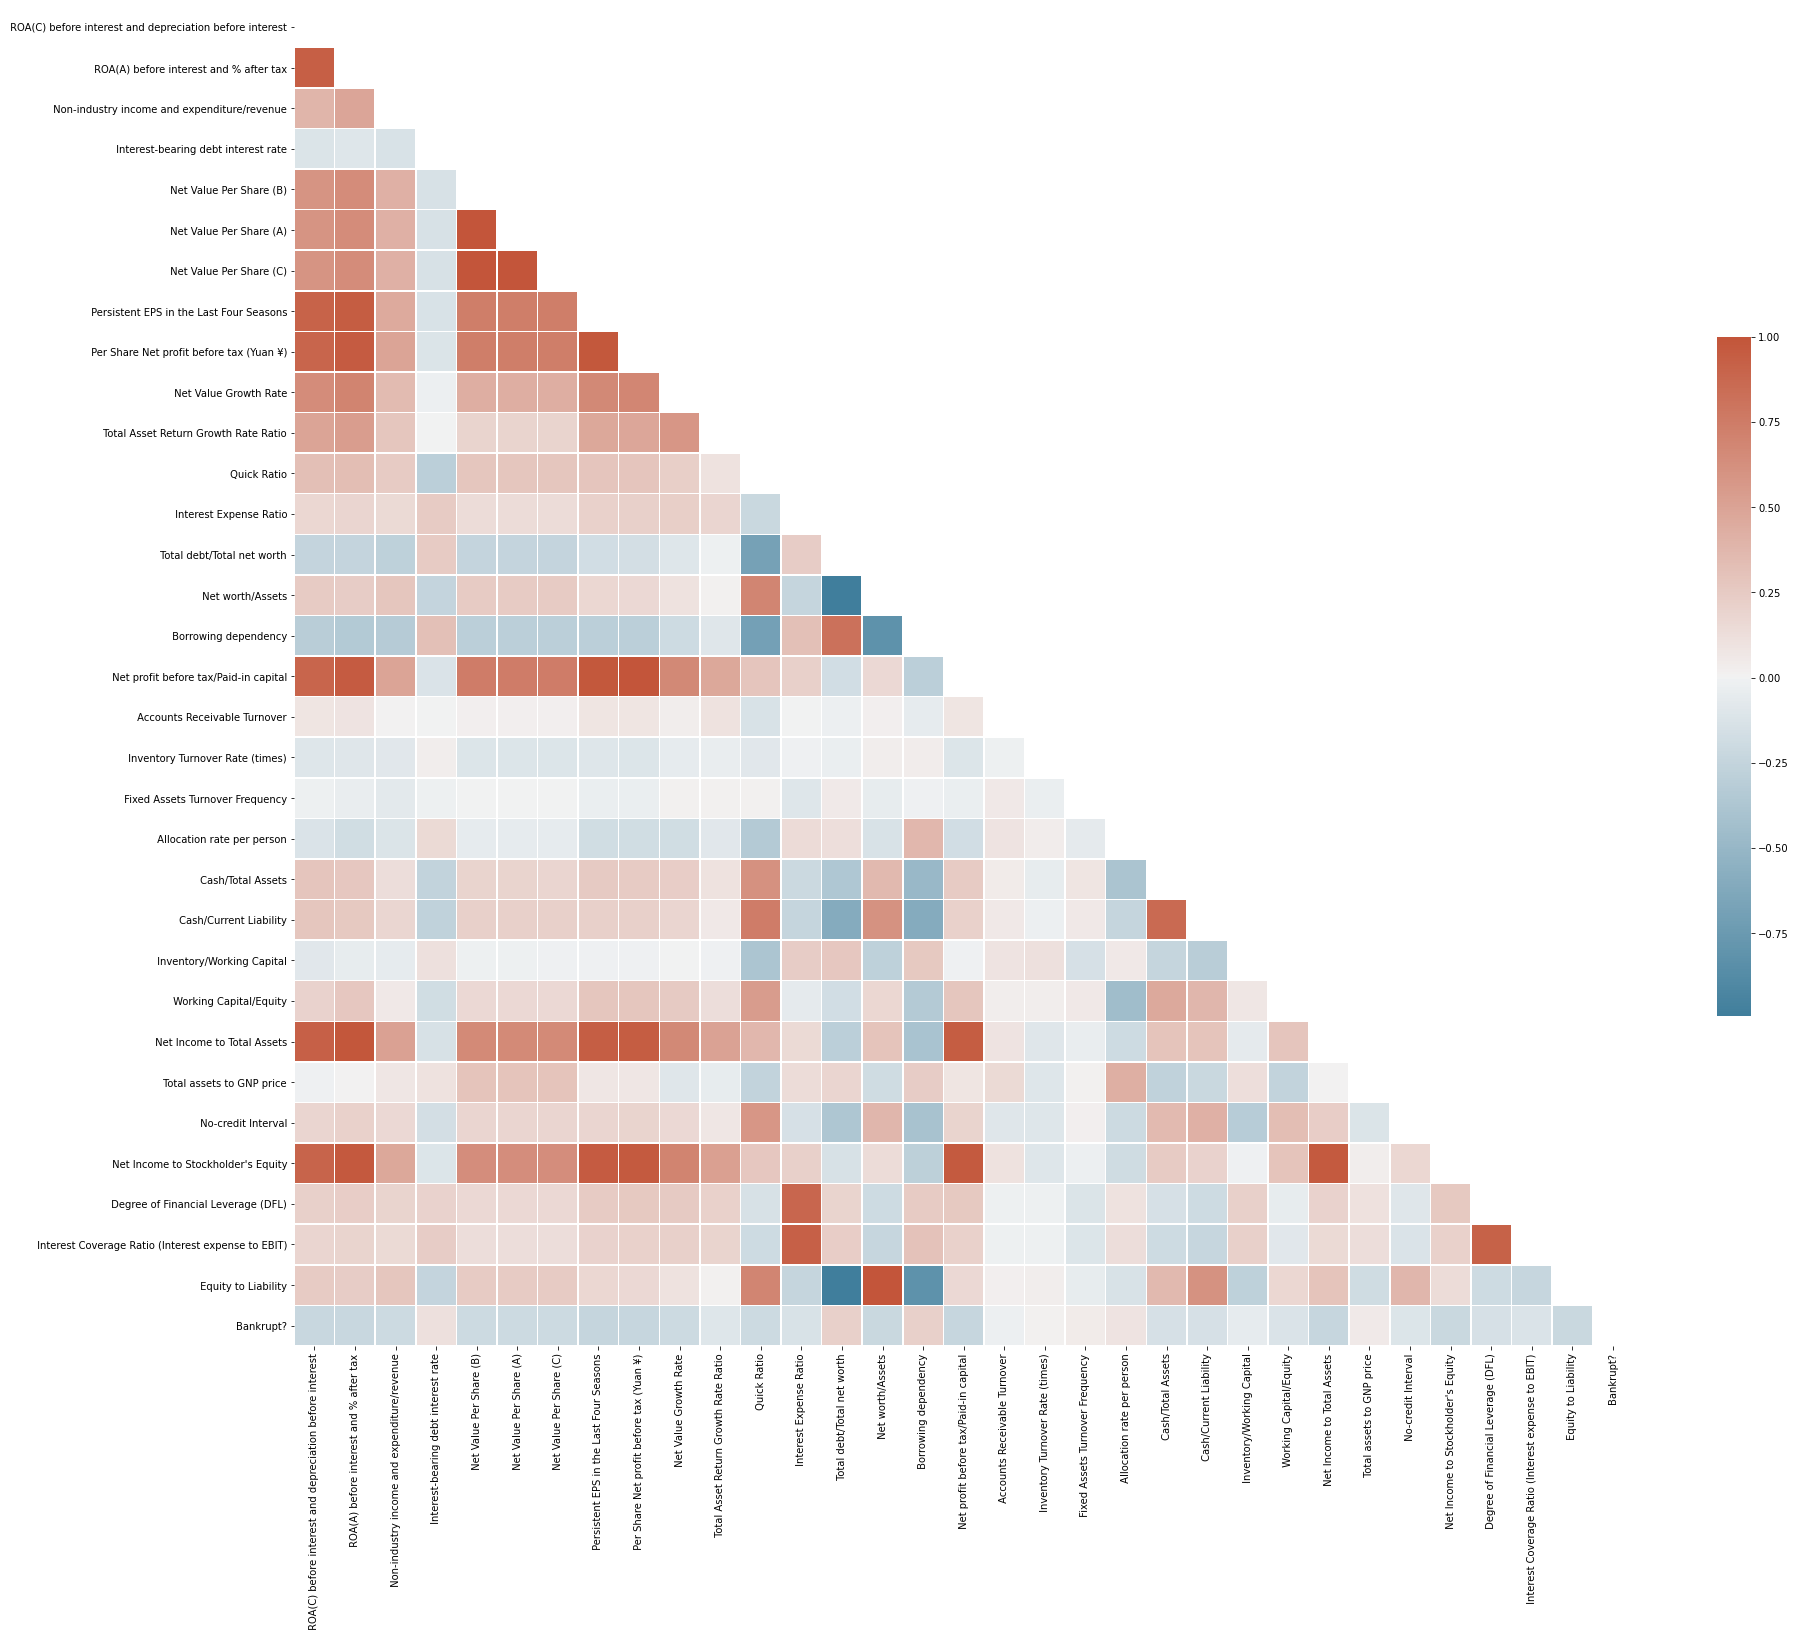

In [14]:
# Correlations
rfecv_df.corr('spearman')["Bankrupt?"].sort_values() 
# Correlation Heatmap (Spearman)
f, ax = plt.subplots(figsize=(30, 25))
mat = rfecv_df.corr('spearman')  
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

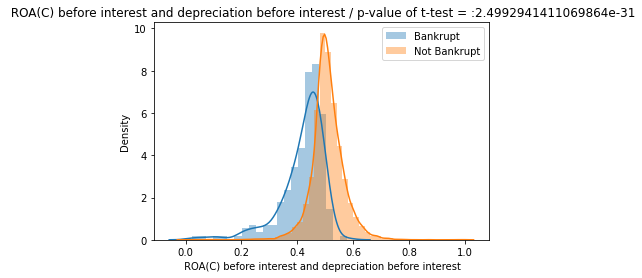

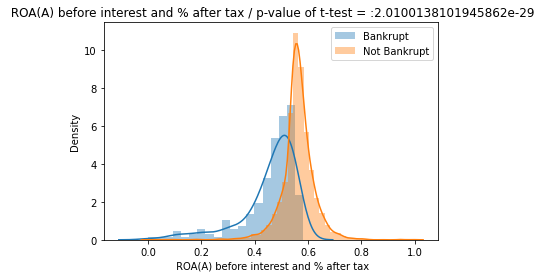

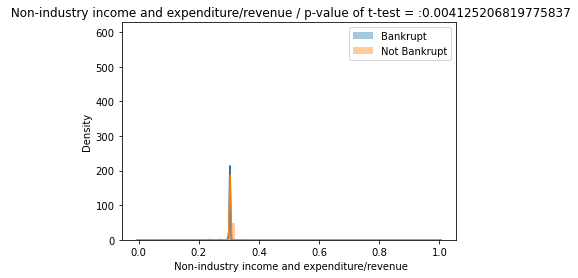

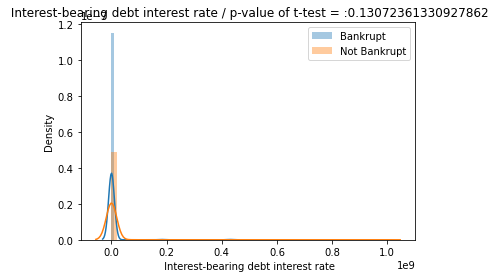

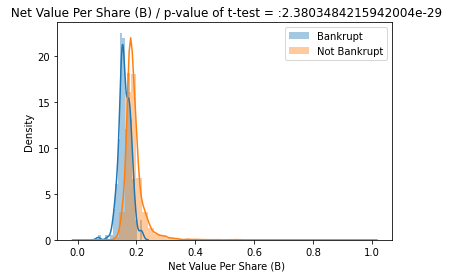

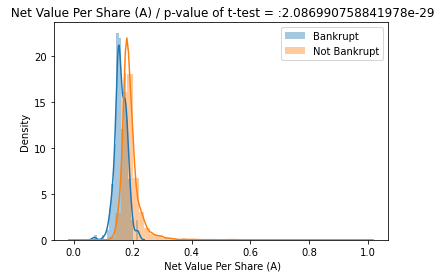

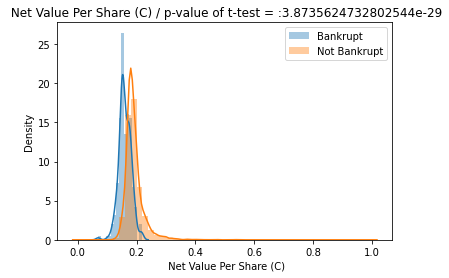

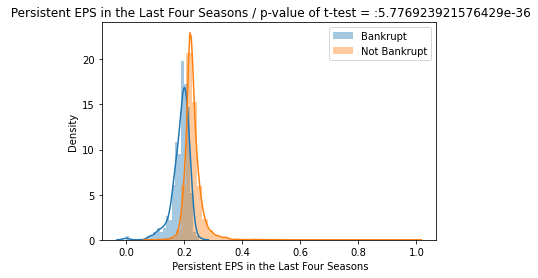

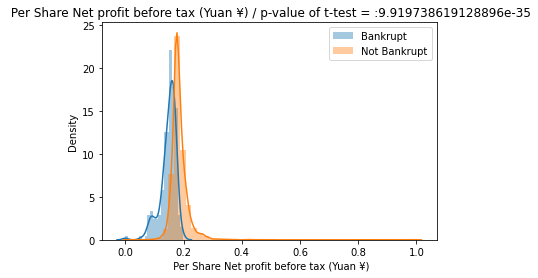

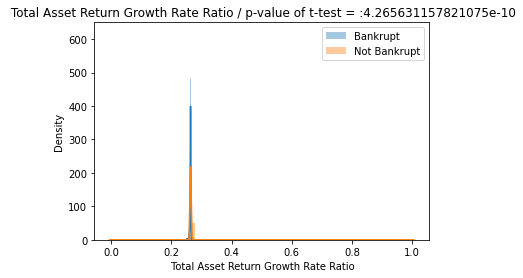

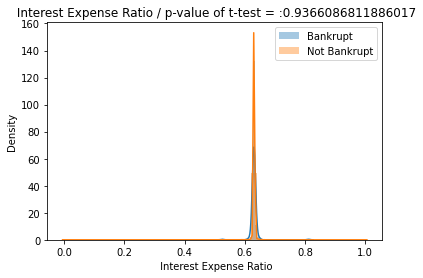

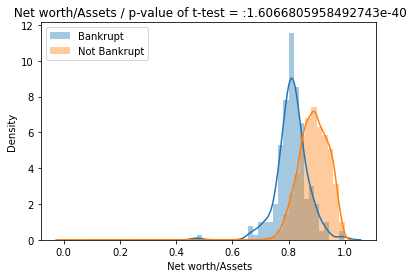

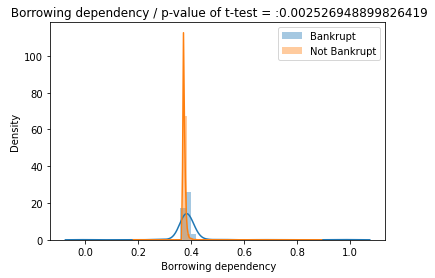

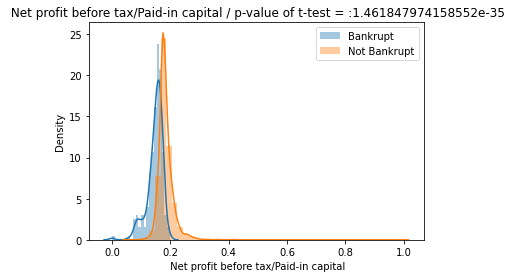

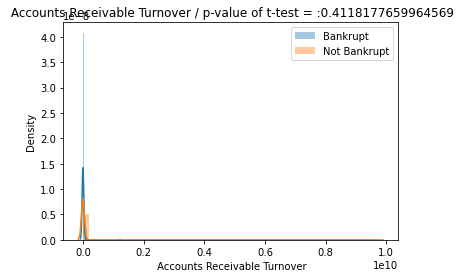

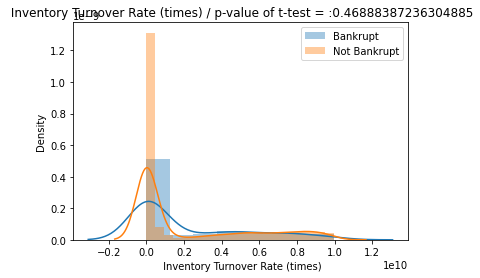

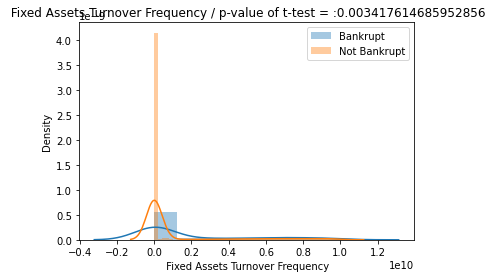

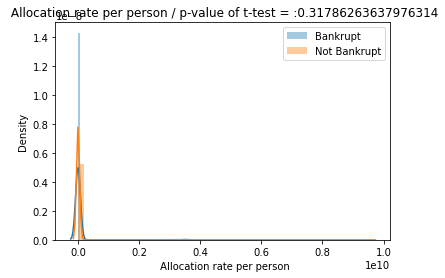

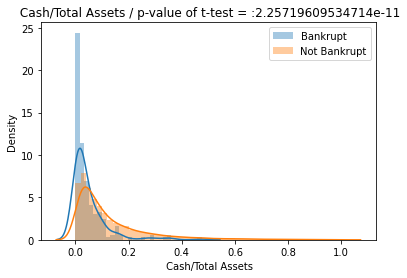

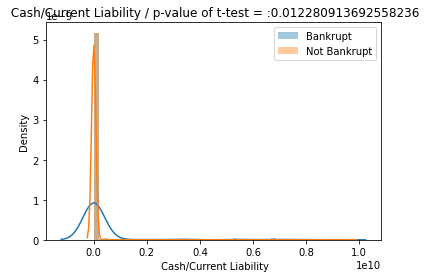

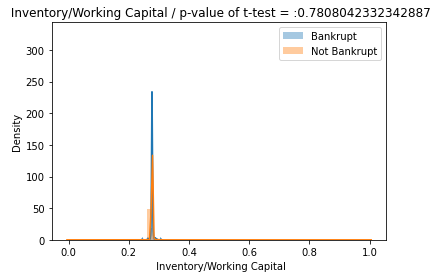

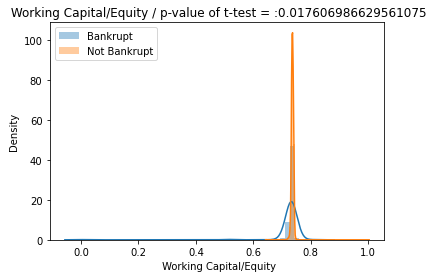

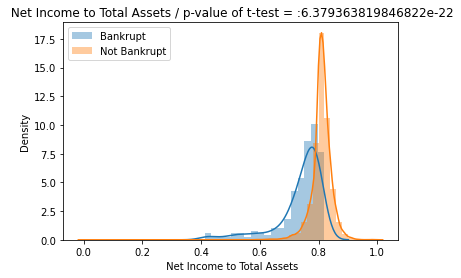

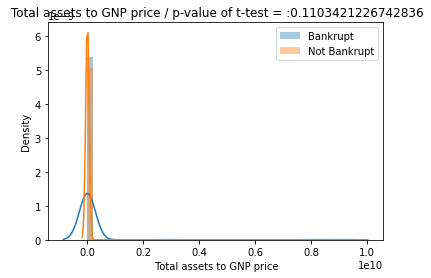

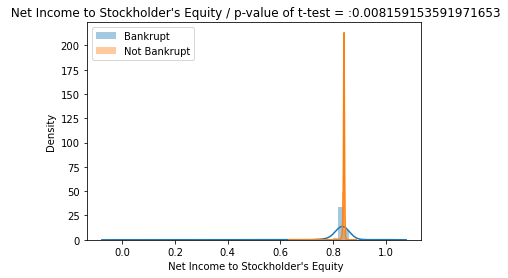

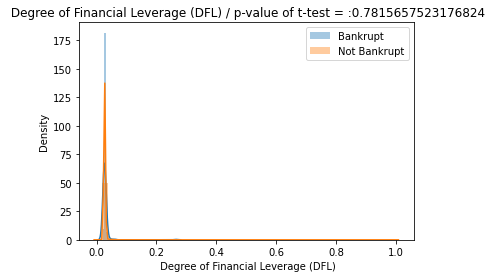

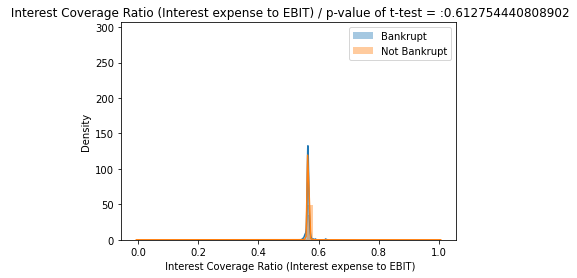

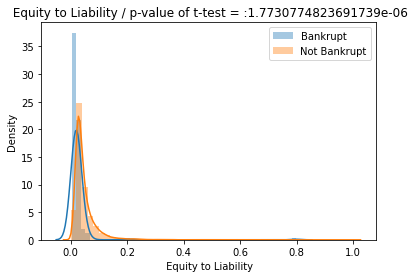

In [17]:
# Seperate dfs
bankrupt_df = rfecv_df[rfecv_df['Bankrupt?']==True]
not_bankrupt_df = rfecv_df[rfecv_df['Bankrupt?']==False]

# Analyze distributions of selected features using rfecv
cols = rfecv_df.drop("Bankrupt?", axis=1).columns

for feature in cols:
  a = bankrupt_df[feature]
  b = not_bankrupt_df[feature]
  b = b.sample(n=len(a), random_state=42) # Take random sample from each feature to match length of target
  # Running t-tests
  test = stats.ttest_ind(a,b)   
  plt.figure() 
  sns.distplot(bankrupt_df[feature], kde=True, label="Bankrupt")
  sns.distplot(not_bankrupt_df[feature], kde=True, label="Not Bankrupt") 
  plt.title("{} / p-value of t-test = :{}".format(feature, test[1]))
  plt.legend()

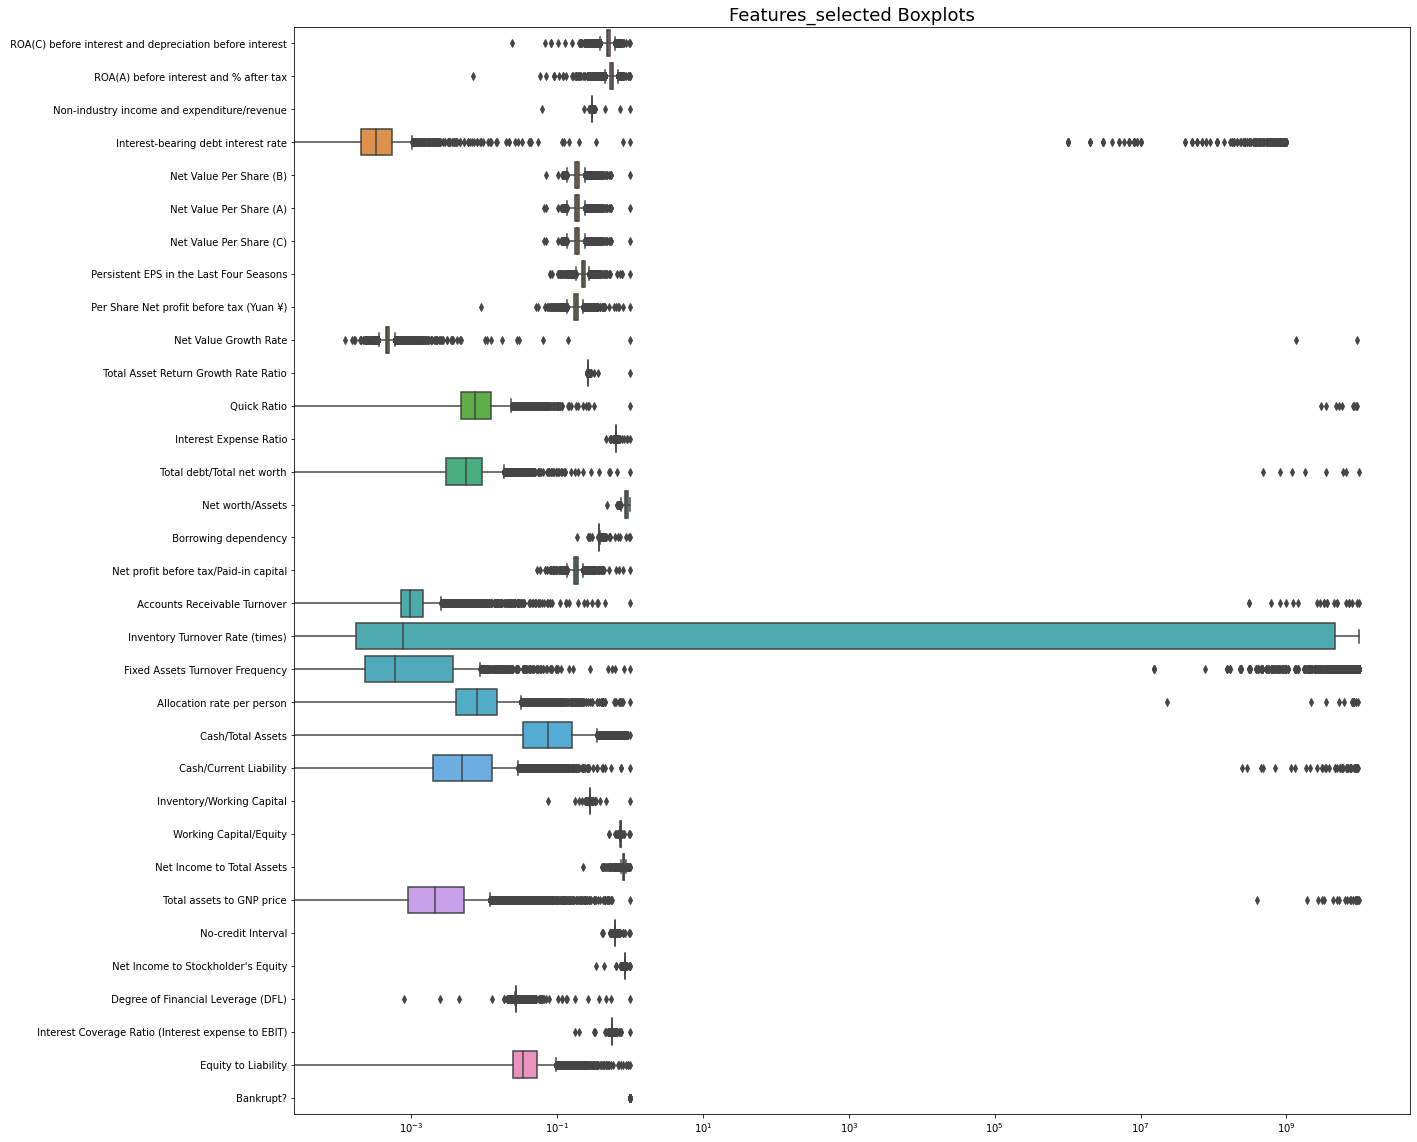

In [18]:
# Visulize outliers using boxplots
plt.figure(figsize = (20,20))
ax =sns.boxplot(data= rfecv_df, orient="h")
ax.set_title('Features_selected Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

In [19]:
# Evaluation function 
def evaluation(model):
  model.fit(X_train, y_train)
  ypred = model.predict(X_test)
  print(confusion_matrix(y_test, ypred))
  print(classification_report(y_test, ypred))
    
  N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=5, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
  plt.figure(figsize=(12, 8))
  plt.plot(N, train_score.mean(axis=1), label='train score')
  plt.plot(N, val_score.mean(axis=1), label='validation score')
  plt.legend()

In [20]:
# Set X and y 
X = rfecv_df.iloc[:, :-1].values
y = rfecv_df.iloc[:, -1].values
# Set training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
# Set models with default params
RandomForest = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=0)
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
# Set dictionary of models
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'KNN': KNN
                  
                 }

RandomForest
[[1641    6]
 [  45   13]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.68      0.22      0.34        58

    accuracy                           0.97      1705
   macro avg       0.83      0.61      0.66      1705
weighted avg       0.96      0.97      0.96      1705

AdaBoost
[[1629   18]
 [  39   19]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1647
           1       0.51      0.33      0.40        58

    accuracy                           0.97      1705
   macro avg       0.75      0.66      0.69      1705
weighted avg       0.96      0.97      0.96      1705

KNN
[[1642    5]
 [  47   11]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.69      0.19      0.30        58

    accuracy                           0.97      1705
   macro avg       0.

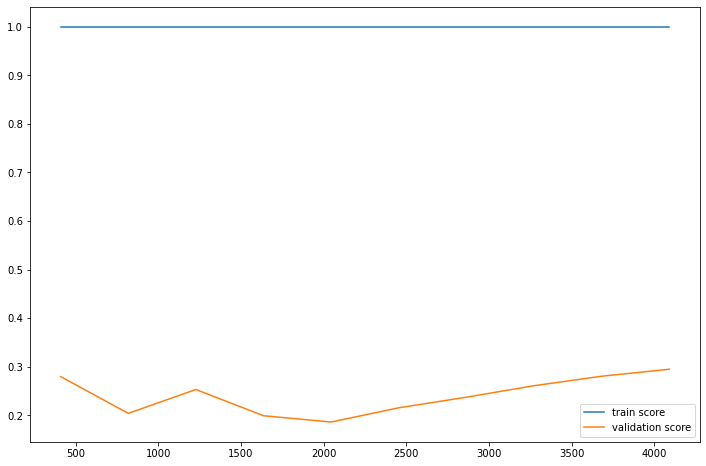

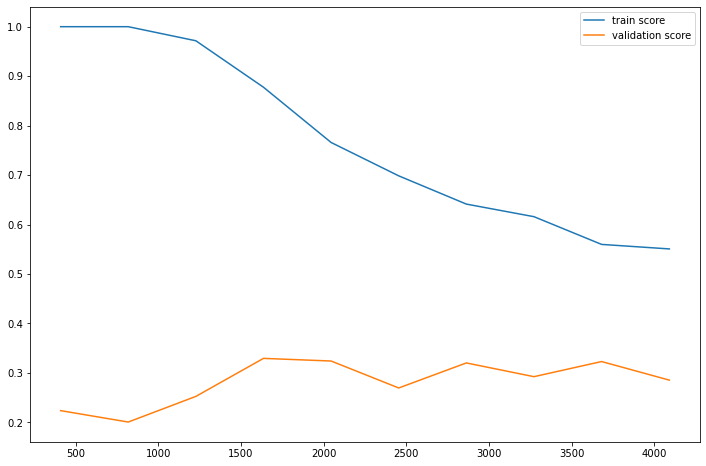

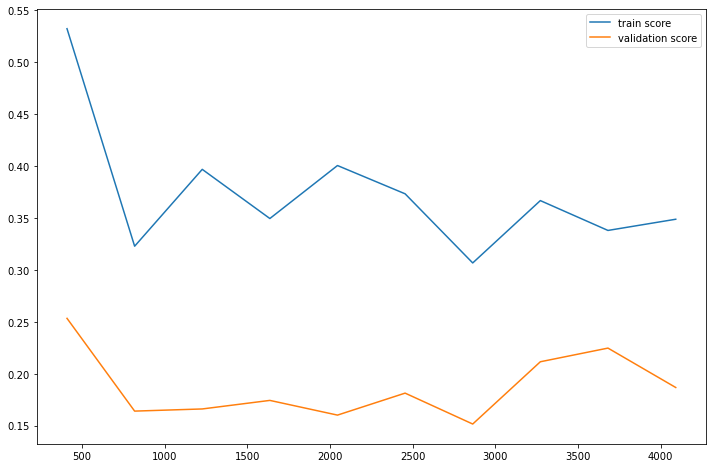

In [22]:
# Evaluate models
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

In [23]:
# USING OVERSAMPLING ONLY
kf = RepeatedStratifiedKFold(n_splits=5)
# Set empty lists to store key metrics
accuracy = []
f1 = []
recall =[]
precision = []
# Loop over kfolds
for kf, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train = X[train_index, :]
    y_train = y[train_index]  
    X_test = X[test_index, :]
    y_test = y[test_index]  
    # Set pipeline where SMOTE with oversampling is applied before model fitting
    model = make_pipeline(SMOTE() ,RandomForestClassifier(random_state=0))
    # Fit model
    model.fit(X_train, y_train)
    # Predict on original test set  
    y_pred = model.predict(X_test)
    # Compute key metrics for target "Bankrupt = 1"
    accuracy.append(model.score(X_test, y_test))
    f1.append(f1_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
# Print key metrics      
print("Mean accuracy:", np.mean(accuracy))
print("Mean f1", np.mean(f1))
print("Mean recall", np.mean(recall))
print("Mean precision", np.mean(precision))

Mean accuracy: 0.9508726868237437
Mean f1 0.4269833370063793
Mean recall 0.5668181818181818
Mean precision 0.34490326577202607
